In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
import sys
import librosa
import sounddevice
sys.path.append('rtvc')

In [38]:
from rtvc import rtvc_api

rtvc_api.load_models('rtvc')

Loaded encoder "pretrained.pt" trained to step 1564501
Trainable Parameters: 4.481M


## RTVC Demo

In [35]:
target_speaker = 'data/librispeech/1040/133433/1040-133433-0002.flac'
target_speaker = 'data/vctk/p234/p234_003.wav'
source, sf = librosa.load(target_speaker, sr=16000)
sounddevice.play(source, 16000)

In [36]:
embed = rtvc_api.get_embedding(target_speaker)

(array([167.,  21.,  22.,  21.,   6.,   7.,   4.,   4.,   2.,   2.]),
 array([0.        , 0.02562771, 0.05125542, 0.07688312, 0.10251083,
        0.12813854, 0.15376624, 0.17939396, 0.20502166, 0.23064938,
        0.25627708], dtype=float32),
 <BarContainer object of 10 artists>)

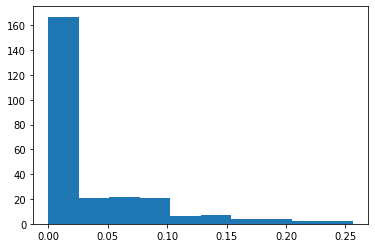

In [45]:
import matplotlib.pyplot as plt
plt.hist(embed)

In [43]:
waveform = rtvc_api.vc('Okay, google! Please buy bitcoin!', embed + 10)
print(f'Waveform: {waveform.shape}')
sounddevice.play(waveform, 16000)

{| ████████████████ 437000/441600 | Batch Size: 46 | Gen Rate: 71.7kHz | }Waveform: (372480,)


In [27]:
sounddevice.play(waveform, 16000)

## Optimization

In [5]:
import os
import pandas as pd

In [6]:
from helpers.dataset import filter_by_gender, Dataset
from helpers.datapipeline import data_pipeline_mv

from models import verifier
from models.mv.model import SiameseModel

In [7]:
train_set = pd.read_csv('data/vs_mv_pairs/mv_train_population_vctk_20u_10s.csv')
x_train, y_train = train_set['filename'], train_set['user_id']
x_train, y_train = filter_by_gender(x_train, y_train, 'data/vs_mv_pairs/meta_data_vctk.csv', 'female')
assert len(x_train) > 0, 'Looks like no user data was loaded! Check your data directories and gender filters'


2021-11-12 11:30:56.116 | INFO     | helpers.dataset:filter_by_gender:216 - Filter data sets by gender
2021-11-12 11:30:56.118 | INFO     | helpers.dataset:filter_by_gender:231 - Filtered by female: 120 audio files from 12 users


In [8]:
train_data = data_pipeline_mv(x_train, y_train, int(16000 * 2.58), 16000, 20, 120, 'spectrum')

In [25]:
test_gallery = Dataset('data/vs_mv_pairs/mv_test_population_vctk_20u_10s.csv')
test_gallery.precomputed_embeddings(sv)

2021-11-12 11:42:10.359 | INFO     | helpers.dataset:save_embeddings:65 - (200, 512)
2021-11-12 11:42:10.360 | INFO     | helpers.dataset:save_embeddings:67 - Embeddings saved for data/vs_mv_data/mv_test_population_vctk_20u_10s/embeddings/vggvox_v000.npz


In [18]:
assert test_gallery.population.shape[0] == test_gallery.embeddings.shape[0], "Number of fetched embeddings does not match #people in the population. Outdated cache?"

In [11]:
from types import SimpleNamespace

In [12]:
# dir_name = utils.sanitize_path(f'{args.netv}_{args.attack}_{args.mv_gender[0]}'.replace('/', '_'))
dir_name = 'temp_vctk'
dir_name = os.path.join('data', 'vs_mv_data', dir_name)

args = SimpleNamespace()

# Basic setup
siamese_model = SiameseModel(dir=dir_name,
                             params=args, 
                             playback=False, 
                             ir_dir='data/vs_noise_data/',
                             run_id=0)

# Set verifier
sv = verifier.get_model('vggvox/v000')
siamese_model.set_verifier(sv)

# Build model
siamese_model.build()

2021-11-12 11:31:03.502 | DEBUG    | models.mv.model:__init__:72 - Output dir exists: data/vs_mv_data/temp_vctk/v000
2021-11-12 11:31:03.503 | INFO     | models.verifier.model:__init__:123 - created model folder ./data/vs_mv_models/vggvox/v000
2021-11-12 11:31:03.503 | INFO     | models.verifier.vggvox:build:47 - building vggvox for 0 classes
2021-11-12 11:31:03.937 | INFO     | models.verifier.model:load:184 - loading pre-trained vggvox
2021-11-12 11:31:03.938 | DEBUG    | models.verifier.model:load:189 - ./data/vs_mv_models/vggvox/v000/model.h5
2021-11-12 11:31:04.556 | INFO     | models.verifier.model:load:194 - loaded checkpoint from ./data/vs_mv_models/vggvox/v000


In [14]:
opt_settings = siamese_model.defaults()

print(opt_settings)

# opt_settings.update({
#     'gradient': args.gradient,
#     'n_epochs': args.n_epochs,
#     'max_attack_vector': args.max_dist,
#     'l2_regularization': args.l2_reg,
#     'learning_rate': args.learning_rate
# })

<models.mv.model.SiameseModel.defaults.<locals>.AttrDict object at 0x7fa142fd4750>


In [28]:
import rtvc_api
rtvc_api.load_models('rtvc')

Loaded encoder "pretrained.pt" trained to step 1564501
Trainable Parameters: 4.481M


In [51]:
siamese_model.setup_attack('nes@cloning', None) # pgd@spec, nes@cloning, pgd@wave
siamese_model.batch_optimize_by_path('data/vs_mv_seed/female/001.wav', train_data, test_gallery, settings=opt_settings)

2021-11-12 12:15:33.964 | INFO     | models.mv.model:batch_optimize_by_path:232 - Starting optimization data/vs_mv_seed/female/001.wav: 1 of 1
2021-11-12 12:15:33.980 | DEBUG    | models.mv.model:optimize:297 - Configured optimization: parameter space (256,)
2021-11-12 12:15:33.985 | INFO     | models.verifier.model:test_error_rates:310 - used thresholds {'eer': 0.7683, 'far1': 0.8343}
2021-11-12 12:15:34.106 | INFO     | models.verifier.model:test_error_rates:310 - used thresholds {'eer': 0.7683, 'far1': 0.8343}


Loaded encoder "pretrained.pt" trained to step 1564501
Trainable Parameters: 4.481M


2021-11-12 12:15:34.202 | DEBUG    | models.mv.model:optimize:310 - (Baseline) Imp@EER m=0.000 f=0.000 | Imp@FAR1 m=0.000 f=0.000


Trainable Parameters: 30.870M
+----------+---+
| Tacotron | r |
+----------+---+
|   295k   | 2 |
+----------+---+
 
{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 6.7kHz | }

2021-11-12 12:28:51.873 | INFO     | models.verifier.model:test_error_rates:310 - used thresholds {'eer': 0.7683, 'far1': 0.8343}
2021-11-12 12:28:52.092 | INFO     | models.verifier.model:test_error_rates:310 - used thresholds {'eer': 0.7683, 'far1': 0.8343}
2021-11-12 12:28:52.174 | DEBUG    | models.mv.model:optimize:351 - (Epoch= 0) Imp@EER m=0.125 f=0.583 | Imp@FAR1 m=0.000 f=0.000 | opt time 791.7 + val time 6.2


{| ███████████░░░░░ 31000/48000 | Batch Size: 5 | Gen Rate: 7.9kHz | }

KeyboardInterrupt: 

In [22]:
test_gallery.population.shape[0], test_gallery.embeddings.shape[0]

(200, 200)

In [20]:
df = pd.read_csv('data/vs_mv_pairs/mv_test_population_vctk_20u_10s.csv')